# Exploring mental health - Introduction - Binary Classification and Deployment with fastai and BentoML.

I use data from a mental health survey to explore factors that may cause individuals to experience depression and use this to classify whether an individual is at risk of depression or not.

The data used for this was synthetically generated from the Depression Survey/Dataset which you can find [here](https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis). The original dataset was collected from a survey carried out among adults aimed at understanding depression risk factors based on inputs provided by particpants in the survey.

> Quoting the dataset description, This dataset was collected as part of a comprehensive survey aimed at understanding the factors contributing
> to depression risk among adults. It was collected during an anonymous survey conducted between January and June 2023. The survey was conducted
> across various cities, targeting individuals from diverse backgrounds and professions. Participants, ranging from 18 to 60 years old, 
> voluntarily provided inputs on factors such as age, gender, city, degree, job satisfaction, study satisfaction, study/work hours, and family 
> history among others. Participants were asked to provide inputs without requiring any professional mental health assessments or diagnostic 
> test scores.

The target variable is either "0" or "1" hence our goal here will be to predict the target class which represent "Yes" and "1".

Exploring this dataset can help us understand and provide key insights into how everyday factors contribute to our mental health. I originally built this as a solution to the exploring mental health data kaggle competition. You can find the solution link [here](https://www.kaggle.com/code/rubanzasilva/eda-gradient-boosting-neural-nets-s04e11).

My goal for this was to deploy the model I built for the above competition. To do this, I serve the model with bentoml, then deploy the model to a cloud provider (bento cloud). This gives me an API that can be used when building our user interface for end-user interaction or integrating our predictions into existing solutions.

## Library Imports
We start by importing the libraries we shall need to build the solution. To install the neccesary libraries before hand. Run **pip install requirements.txt** via your terminal while in this project directory. This will automatically install the dependencies defined in the requirements.txt file.

In [ ]:
import numpy as np
from numpy import random
#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
#import matplotlib.pyplot as plt
#from fastai.imports import *
#np.set_printoptions(linewidth=130)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from pathlib import Path
import os
import xgboost as xgb
#from xgboost import plot_importance
from xgboost import XGBClassifier
import warnings
import gc
import pickle
from joblib import dump, load
import typing as t
import bentoml
from bentoml.validators import DataframeSchema

torch.manual_seed(42)

## Define data path / location

In [2]:
path = Path('data/')

train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')

## Data Preprocessing

Below I prepare my data for machine learning using the below fastai functions. Once my data is in a suitable format for machine learning training, we pass it to an XGBoost model which is a popular gradient boosting based framework that works quite efficiently for tabular data.

First, we define categorical and continuous variables, I use the fastai [cont_cat_split](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continuous variables based on the cardinality of my column values.

This takes an argument max card whose default is 20. If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continuous, and vice versa.

In [3]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')

### Split into training and validation set 
The [RandomSplitter](https://docs.fast.ai/data.transforms.html#randomsplitter) below separates the training set into a training and validation set based on the value of the argument valid_pct.

In [4]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

### TabularPandas
Below we define a [TabularPandas](https://docs.fast.ai/tabular.core.html#tabularpandas) object.
Here we declare the continuous and categorical columns, the dataset splitting strategy, the preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting, and the type of problem we are optimizing for such as binary classification in this case.



In [5]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Depression',
                   y_block=CategoryBlock(),
                   splits=splits)

/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

### DataLoaders
We define a dataloaders which prepares our data for input into our neural network.Here we can define our batch size.

In [6]:
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/home/rubanza/.local/lib/python3.10/site-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

### Fastai intergation with other libraries

To quote the fastai documentation
> Integration with libraries such as Random Forests and XGBoost requires only one extra step, that the .dataloaders call did for us. Let’s look
> at our to again. Its values are stored in a DataFrame like object, where we can extract the cats, conts, xs and ys if we want to:

In [7]:
to.xs[:3]

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness,...,Job Satisfaction_na,Financial Stress_na,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress
id,,,,,,,,,,,,,,,,,,,,,
129184,120,2,59,2,15,16,16,20,1,2,...,1,1,1.422830,-0.04561,1.591172,0.033461,0.01841,-1.561847,-0.842910,0.714559
45392,184,2,87,2,4,30,16,90,2,2,...,1,1,0.777218,-0.04561,-0.794526,0.033461,0.01841,-1.561847,-0.065067,0.714559
40955,218,1,38,2,56,28,21,76,1,2,...,1,1,0.373710,-0.04561,0.795939,0.033461,0.01841,-0.772831,0.194214,-1.406225


> Now that everything is encoded, you can then send this off to XGBoost or Random Forests by extracting the train and validation sets and their
> values:

In [8]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

## Train and save a model

We can now use the above directly with our XGBoost library. The below code calls trains a XGBoost Classifier model.

In [9]:
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

#xgb_preds = tensor(xgb_model.predict(test_dl.xs))
#xgb_preds_x = tensor(xgb_model.predict(X_test))
#accuracy = accuracy_score(y_test, xgb_preds_x)
#print(f"Model accuracy: {accuracy}")

After training, we use the **bentoml.xgboost.save_model** API to save the model to the bentoml model store. This is a local storage that bentoml has to store and manage models etc. This models can be accessed later by calling them and they can be used to make new predictions.

In [10]:
bentoml.xgboost.save_model("mental_health_v1", xgb_model)

Model(tag="mental_health_v1:qud2aig33o5qbjo7", path="/home/rubanza/bentoml/models/mental_health_v1/qud2aig33o5qbjo7/")

We can check for our model by running the below code.

In [ ]:
!bentoml models list
#if running via terminal, use bentoml model list directly.

 Tag                           Module           Size        Creation Time       
 mental_health_v1:qud2aig33o…  bentoml.xgboost  432.87 KiB  2025-01-26 14:48:54 
 mental_health_v1:2plmd4g32c…  bentoml.xgboost  421.24 KiB  2025-01-26 13:32:22 
 mental_health_v1:axqqhmg3z6…  bentoml.xgboost  421.24 KiB  2025-01-26 13:19:27 
 mental_health_v1:iz77zng3ec…  bentoml.xgboost  421.24 KiB  2025-01-25 16:28:34 
 mental_health_v1:4qpareg3d6…  bentoml.xgboost  421.24 KiB  2025-01-25 16:25:48 
 sticker_sales_v1:lhotw4gyr6…  bentoml.xgboost  476.22 KiB  2025-01-22 10:06:07 
 mental_health_v1:exbjk3wm4k…  bentoml.xgboost  421.24 KiB  2025-01-07 13:28:34 


### Test the model

The previous cell outputs the models we have saved

| Tag | Module | Size | Creation Time |
|-----|--------|------|---------------|
| mental_health_v1:qud2aig33o… | bentoml.xgboost | 432.87 KiB | 2025-01-26 14:48:54 |

Our next mode is to test the model we have just saved. This ensures that the model we saved runs as expected. 
We start by loading our saved model mental_health_v1:qud2aig33o5qbjo7.

In [13]:
# Load the model by setting the model tag
booster = bentoml.xgboost.load_model("mental_health_v1:qud2aig33o5qbjo7")

In [14]:
# Uncomment cells if running this test case in a separate file
#path = Path('data/')
#test_df = pd.read_csv(path/'test.csv',index_col='id')
#train_df = pd.read_csv(path/'train.csv',index_col='id')
#cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
#to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   #cat_names = cat_names,
                   #cont_names = cont_names,
                   #y_names='Depression',
                   #y_block=CategoryBlock(),
                   #splits=splits)
#dls = to.dataloaders(bs=64)
#test_dl = dls.test_dl(test_df)

res = tensor(booster.predict(test_dl.xs))
print(res)

tensor([0, 0, 0,  ..., 0, 1, 0])


Expected results 

*tensor([0, 0, 0,  ..., 0, 1, 0])*

## Create a BentoML service

First, we use a **@bentoml.service** to define a bentoml service and also define additional configurations like reosurce allocation and timeout.

I load our model from the model store and define it as a class variable. I then create a function **preprocess** to take in our input data and pass it through the same steps we did when training and testing our model.

from here, we can use the **@bentoml.api** to expose our predict functions as API endpoints. This defines what our model input is for example below our predict function expects data in the form of a pandas data frame while our predict_csv function expects a CSV file as the name would suggest.

Furthermore, I also define the expected output type which is a numpy array for the below cases. I then pass our data through the preprocessing function defined previously and finally return the new predictions on the test data.

In [16]:
@bentoml.service(
    resources={"cpu": "8"},
    traffic={"timeout": 10},
)

class MentalHealthClassifier:
    #retrieve the latest version of the model from the BentoML model store
    bento_model = bentoml.models.get("mental_health_v1:latest")
    #bento_model = BentoModel('mental_health_v1:q5kcqtf5ys3qoaav')


    def __init__(self):
        self.model = bentoml.xgboost.load_model(self.bento_model)

    def preprocess(self, data):
        path = Path('data/')
        train_df = pd.read_csv(path/'train.csv',index_col='id')
        test_df = pd.read_csv(path/'test.csv',index_col='id')
        cont_names,cat_names = cont_cat_split(train_df, dep_var='Depression')
        splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
        to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                           cat_names = cat_names,
                           cont_names = cont_names,
                           y_names='Depression',
                           y_block=CategoryBlock(),
                           splits=splits)
        dls = to.dataloaders(bs=64)
        test_dl = dls.test_dl(data)
        test_df_new = test_dl.xs
        return test_df_new
  

    @bentoml.api
    def predict(self, data:pd.DataFrame) -> np.ndarray:
        data = self.preprocess(data)
        prediction = self.model.predict(data)
        #prediction = torch.tensor(prediction)
        return prediction
 
    
    @bentoml.api()
    def predict_csv(self,csv:Path) -> np.ndarray:
        csv_data = pd.read_csv(csv)
        csv_data = self.preprocess(csv_data)
        prediction_csv = self.model.predict(csv_data)
        return prediction_csv

`bentoml.models.get()` as the class attribute is not recommended because it requires the model to exist at import time. Use `bento_model = BentoModel('mental_health_v1:qud2aig33o5qbjo7')` instead.


We then run this by running **bentoml serve service:MentalHealthClassifier** in our project directory which starts our service.

The server is now active via http://localhost:3000/ as shown below. You can interact with it using swagger UI, CURL or with a python client.

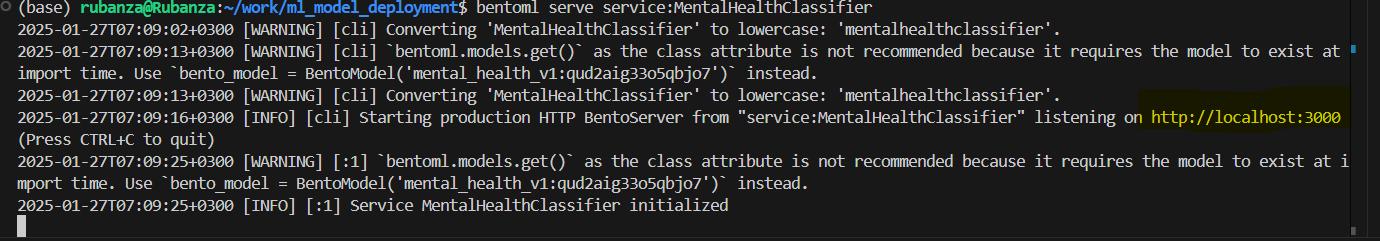

## Deploy to a cloud provider

We push our service to a cloud provider so other people can interact with our API.